In [2]:
!pip install pandas matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 10.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [seaborn]m3/4 [seaborn]


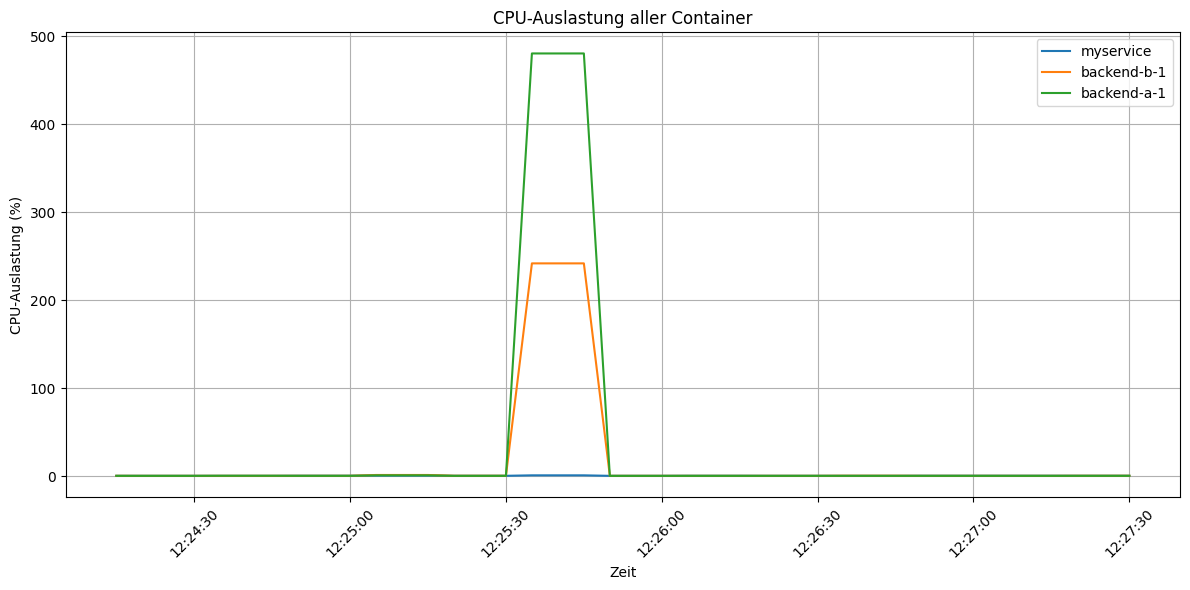

In [10]:
import requests
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

# 🔗 Prometheus-URL
prometheus_url = "http://localhost:9090"

# ⏱ Zeitraum definieren (aus Annotation z. B.)
start_time = datetime.strptime("2025-05-23 12:24:15", "%Y-%m-%d %H:%M:%S")
end_time = datetime.strptime("2025-05-23 12:27:30", "%Y-%m-%d %H:%M:%S")

# UNIX-Timestamps
start = int(start_time.timestamp())
end = int(end_time.timestamp())
step = "5s"

# 📈 PromQL Query
promql_query = 'dockerstats_cpu_usage_ratio{name=~"myservice|backend-a-1|backend-b-1"}'

# 📡 Prometheus API Query
response = requests.get(f"{prometheus_url}/api/v1/query_range", params={
    "query": promql_query,
    "start": start,
    "end": end,
    "step": step
})

# 🔄 Datenverarbeitung
data = response.json()
results = []

for serie in data["data"]["result"]:
    container_name = serie["metric"]["name"]
    timestamps = [datetime.fromtimestamp(float(v[0])) for v in serie["values"]]
    values = [float(v[1]) for v in serie["values"]]
    df = pd.DataFrame({"time": timestamps, container_name: values})
    results.append(df.set_index("time"))

# ⬆️ Merge aller Container-Zeitreihen
if results:
    df_all = pd.concat(results, axis=1)
    
    # 📊 Plot
    plt.figure(figsize=(12, 6))
    for column in df_all.columns:
        plt.plot(df_all.index, df_all[column], label=column)
    plt.title("CPU-Auslastung aller Container")
    plt.xlabel("Zeit")
    plt.ylabel("CPU-Auslastung (%)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Keine Daten gefunden.")


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [43]:
df = pd.read_csv("../jmeter/results/circuitbreaker_2025-05-02_14-23-27/results.jtl")
docker_df = pd.read_csv("../jmeter/results/circuitbreaker_2025-05-02_14-23-27/docker_stats_live.csv", header=None)


In [7]:
df.head()  # Zeige erste Zeilen
df.columns  # Zeige alle Spaltennamen


Index(['timeStamp', 'elapsed', 'label', 'responseCode', 'responseMessage',
       'threadName', 'dataType', 'success', 'failureMessage', 'bytes',
       'sentBytes', 'grpThreads', 'allThreads', 'URL', 'Latency', 'IdleTime',
       'Connect'],
      dtype='object')

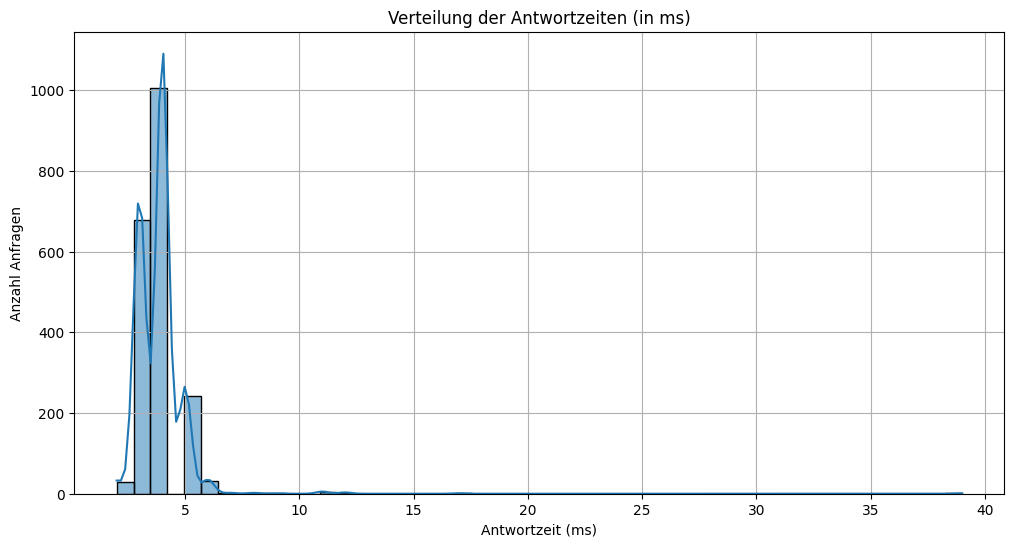

In [8]:
plt.figure(figsize=(12,6))
sns.histplot(df["elapsed"], bins=50, kde=True)
plt.title("Verteilung der Antwortzeiten (in ms)")
plt.xlabel("Antwortzeit (ms)")
plt.ylabel("Anzahl Anfragen")
plt.grid(True)
plt.show()


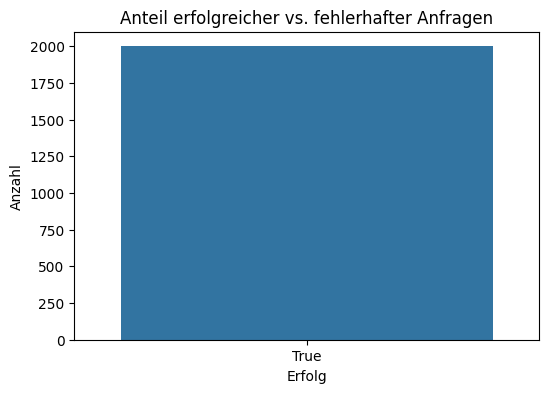

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="success")
plt.title("Anteil erfolgreicher vs. fehlerhafter Anfragen")
plt.xlabel("Erfolg")
plt.ylabel("Anzahl")
plt.show()


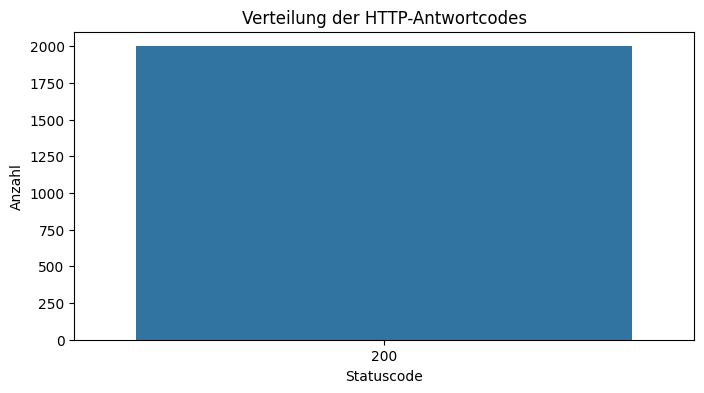

In [10]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="responseCode")
plt.title("Verteilung der HTTP-Antwortcodes")
plt.xlabel("Statuscode")
plt.ylabel("Anzahl")
plt.show()


In [11]:
mean_rt = df["elapsed"].mean()
median_rt = df["elapsed"].median()
p95_rt = df["elapsed"].quantile(0.95)
max_rt = df["elapsed"].max()

total_requests = len(df)
failed_requests = len(df[df["success"] == False])
error_rate = (failed_requests / total_requests) * 100

print(f"🔢 Gesamtanzahl Anfragen: {total_requests}")
print(f"❌ Fehlerhafte Anfragen: {failed_requests} ({error_rate:.2f}%)")
print(f"⏱️ Durchschnittliche Antwortzeit: {mean_rt:.2f} ms")
print(f"⏱️ Median der Antwortzeit: {median_rt:.2f} ms")
print(f"⏱️ 95. Perzentil der Antwortzeit: {p95_rt:.2f} ms")
print(f"⏱️ Maximale Antwortzeit: {max_rt:.2f} ms")


🔢 Gesamtanzahl Anfragen: 2000
❌ Fehlerhafte Anfragen: 0 (0.00%)
⏱️ Durchschnittliche Antwortzeit: 3.85 ms
⏱️ Median der Antwortzeit: 4.00 ms
⏱️ 95. Perzentil der Antwortzeit: 5.00 ms
⏱️ Maximale Antwortzeit: 39.00 ms


In [44]:
def parse_mem_usage(s):
    if isinstance(s, str):
        s = s.strip()
        num = ''.join(filter(lambda c: c.isdigit() or c == '.', s))
        unit = ''.join(filter(str.isalpha, s))
        try:
            num = float(num)
            if unit == "KiB":
                return num / 1024
            elif unit == "MiB":
                return num
            elif unit == "GiB":
                return num * 1024
        except ValueError:
            return None
    return None



docker_df.columns = ["Name", "CPU", "MemUsage", "NetIO"]

docker_df["CPU_percent"] = docker_df["CPU"].str.replace('%', '', regex=False).astype(float)

docker_df["MemUsedRaw"] = docker_df["MemUsage"].str.extract(r"^([^/]+)")[0]
docker_df["Mem_MB"] = docker_df["MemUsedRaw"].map(parse_mem_usage)

docker_df[["Name", "CPU_percent", "Mem_MB"]].head()

,Name,CPU_percent,Mem_MB
0,prometheus,0.63,69.85
1,grafana,0.93,96.79
2,backend-b-1,0.10,507.20
3,myservice,0.11,687.10
4,backend-a-1,0.11,420.20


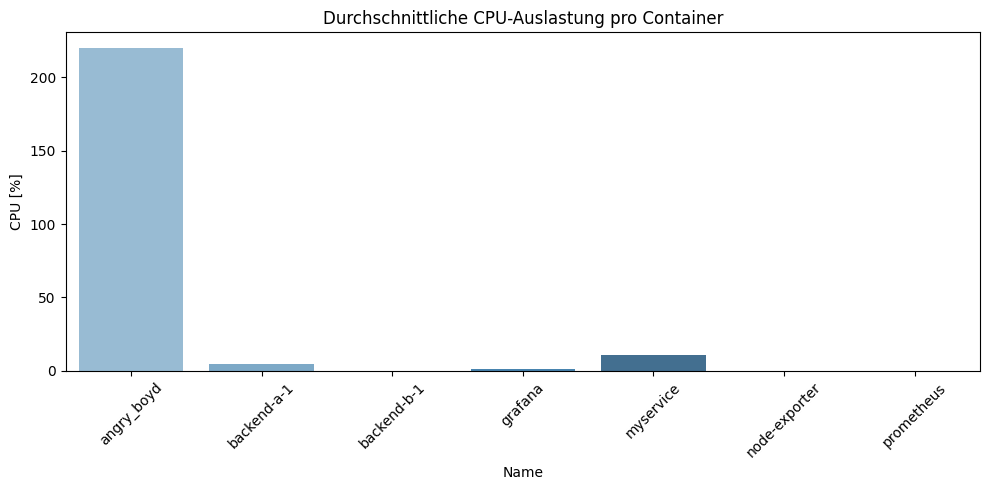

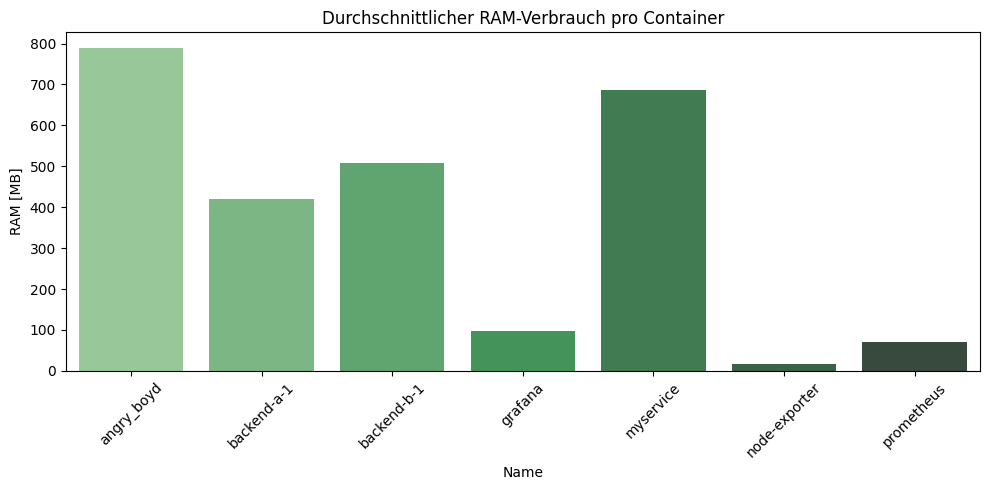

In [52]:
# Gruppieren nach Containername und Mittelwerte berechnen
avg_df = docker_df.groupby("Name")[["CPU_percent", "Mem_MB"]].mean().reset_index()

# Plot: CPU-Nutzung
plt.figure(figsize=(10, 5))
sns.barplot(data=avg_df, x="Name", y="CPU_percent",hue="Name", palette="Blues_d", legend=False)
plt.title("Durchschnittliche CPU-Auslastung pro Container")
plt.ylabel("CPU [%]")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: RAM-Nutzung
plt.figure(figsize=(10, 5))
sns.barplot(data=avg_df, x="Name", y="Mem_MB", hue="Name", palette="Greens_d", legend=False)
plt.title("Durchschnittlicher RAM-Verbrauch pro Container")
plt.ylabel("RAM [MB]")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [54]:
interval_sec = 0.5  # dein Intervall
docker_df["Time_sec"] = docker_df.index * interval_sec

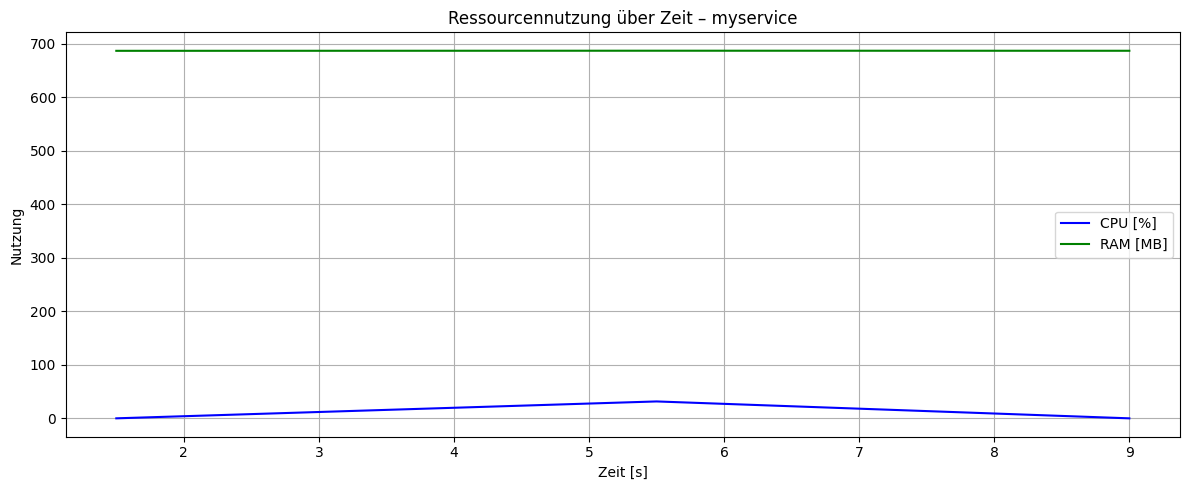

In [55]:
service_name = "myservice"
service_df = docker_df[docker_df["Name"] == service_name]

plt.figure(figsize=(12, 5))
plt.plot(service_df["Time_sec"], service_df["CPU_percent"], label="CPU [%]", color="blue")
plt.plot(service_df["Time_sec"], service_df["Mem_MB"], label="RAM [MB]", color="green")
plt.title(f"Ressourcennutzung über Zeit – {service_name}")
plt.xlabel("Zeit [s]")
plt.ylabel("Nutzung")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
